# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence


Project Abstract: 
With the rapid increase of the in-situ measurements of the solar wind plasma, traditional data analysis methods are no longer sufficient for Heliophysics scientists to fully comprehend the scientific insights embedded within the data. Applications of Machine learning (ML) and Artificial Intelligence (AI) techniques on the solar data in order to perform feature selection, dimension reduction and clustering is the major goal of this proposal.

# Predictive Analytics / Modeling

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import warnings



In [2]:
#Read CSVs

#Just HCS
hcs_df = pd.read_csv('../data/HCS Cleaned.csv')
hcs_df['actual_date'] = pd.to_datetime(hcs_df['actual_date'])  

#HCS + Sunspots
hcs_sun = pd.read_csv("../data/HCS + Sunspots.csv")
#filtering for the important columns
hcs_sun = hcs_sun[['date','SD_70','SL_70_log10','monthly_sunspots','cycle','year','month']]
hcs_sun['date'] = pd.to_datetime(hcs_sun['date']) 

#HCS + Sinsports + ACE
hcs_sun_ace= pd.read_csv("../data/HCS + Sunspots + ACE.csv")
hcs_sun_ace['date'] = pd.to_datetime(hcs_sun_ace['date']) 

In [3]:
print("Number of rows on HCS + Sunspots:",hcs_sun.shape[0])
print("Number of rows on HCS + Sunspots + ACE:",hcs_sun_ace.shape[0])

Number of rows on HCS + Sunspots: 552
Number of rows on HCS + Sunspots + ACE: 278


# Outcome Variables

As mentioned on the EDA, the two outcome varianbles we are interested in are:

- **SD_70** - Integral of the wave's slope at a 70-degree latitude, quantifying the deviation of the HCS from the equator.
- **SL_70_log10** - Measurement of the current plane's tilt at 70 degrees latitude, indicating the HCS's waviness. We calculated the log to make it more compatible with SD.


# Preliminary models

## HCS with Sunspots and ACE
Getting really bad results with this df. It's reduced partly because the ACE data only starts from 1998


In [4]:
#Creating copy of df and droping NAs
hcs_sun_ace_model = hcs_sun_ace.copy().dropna()

#Selecting features
features = hcs_sun_ace_model[['monthly_sunspots','proton_density', 'proton_temp', 'He4toprotons','proton_speed','year','month', 'PC1','PC2']]

#Tried using the results from PCA as features but it didn
features = hcs_sun_ace_model[['monthly_sunspots','year','month', 'PC1','PC2']]

#Scaling features
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled = scaler.fit_transform(features)

#Putting them in a df for the patition
X = pd.DataFrame(scaled, columns=features.columns, index=features.index)

#Outcome variables
y_std = hcs_sun_ace_model['SD_70']
y_slope = hcs_sun_ace_model['SL_70_log10']

In [5]:
#Doing a sequential split
split_point = int(len(hcs_sun_ace_model) * 0.8)  # 80% for training, 20% for testing

# # Training and testing split for standard deviation prediction
X_train_std = X.iloc[:split_point]
X_test_std = X.iloc[split_point:]
y_train_std = y_std.iloc[:split_point]
y_test_std = y_std.iloc[split_point:]

# # Training and testing split for slope prediction
X_train_slope = X.iloc[:split_point]
X_test_slope = X.iloc[split_point:]
y_train_slope = y_slope.iloc[:split_point]
y_test_slope = y_slope.iloc[split_point:]

In [6]:
# # Model for predicting standard deviation
model_std = LinearRegression().fit(X_train_std, y_train_std)

# # Model for predicting slope
model_slope = LinearRegression().fit(X_train_slope, y_train_slope)

# # Evaluating the models using R^2 score or other relevant metrics
std_score = model_std.score(X_test_std, y_test_std)

slope_score = model_slope.score(X_test_slope, y_test_slope)

print("STD Model R^2 with ACE:", std_score)
print("Slope Model R^2 with ACE:", slope_score)

STD Model R^2 with ACE: -3.3871416489335386
Slope Model R^2 with ACE: -6.24160772555945


Unfortunately, given that the ACE dataset only starts from 1998, it cuts downs the HCS data by 20 years, which is significant considering the data is monthly. Additionally, the ACE is in hours and, aggregating these measures to month, doesn't seem compatible with HCS or sunsports--the nuances of these measures aren't captured.

## HCS with only Sunspots
Trying modeling without the ACE data features and using sklearn

In [7]:
#Creating copy of df and droping NAs
hcs_sun_model_pre = hcs_sun.copy().dropna()

#Selecting filters
features = hcs_sun_model_pre[['monthly_sunspots','cycle','year','month']]

#Scaling features
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled = scaler.fit_transform(features)

#Putting them in a df for the patition
X = pd.DataFrame(scaled, columns=features.columns, index=features.index)

#Outcome variables
y_std = hcs_sun_model_pre['SD_70']
y_slope = hcs_sun_model_pre['SL_70_log10']


In [8]:
# # Training and testing split for standard deviation prediction
#Doing a sequential split. This is to avoid data leakage. Data frame was sorted above
split_point = int(len(hcs_sun_model_pre) * 0.8)  # 80% for training, 20% for testing

X_train_std = X.iloc[:split_point]
X_test_std = X.iloc[split_point:]
y_train_std = y_std.iloc[:split_point]
y_test_std = y_std.iloc[split_point:]

# # Training and testing split for slope prediction
X_train_slope = X.iloc[:split_point]
X_test_slope = X.iloc[split_point:]
y_train_slope = y_slope.iloc[:split_point]
y_test_slope = y_slope.iloc[split_point:]

In [9]:
# # Model for predicting standard deviation
model_std = LinearRegression().fit(X_train_std, y_train_std)

# # Model for predicting slope
model_slope = LinearRegression().fit(X_train_slope, y_train_slope)


# # Evaluating the models using R^2 score or other relevant metrics
std_score = model_std.score(X_test_std, y_test_std)
slope_score = model_slope.score(X_test_slope, y_test_slope)


print("STD Model R^2:", std_score)
print("Slope Model R^2:", slope_score)

STD Model R^2: 0.18186803624750014
Slope Model R^2: 0.25169542283702817


Still not great results but at least we are getting an R^2 of above 0. Thus, this is our **baseline model**

# Feature Engineering

Now that we have decided to exclude the ACE mission data. We will be doing some feature engineering.

In [10]:
#Creating copy of df and droping NAs
hcs_sun_model = hcs_sun.copy().dropna()

#When we did EDA, we created some columns that we will like to use as features

## year and month of the aggregated the date
hcs_sun_model['year']
hcs_sun_model['month']

## cycles last 11 years on average 
hcs_sun_model['cycle']

#Additionally, given the data limitations, we wanted to explore using lag columns as features
#However, we needed to follow some steps to get the lags correctly.

#To avoid using a wrong row as a lag, we used the date as the index. 
#Thus, we are looking at an actual date and not just a row

hcs_sun_model['date'] = pd.to_datetime(hcs_sun_model['date'])  # Convert to datetime
hcs_sun_model.set_index('date', inplace=True)  # Set as index
hcs_sun_model.sort_index(inplace=True)  # Sort by the datetime index

# Now, creating the lag columns
hcs_sun_model['SD_70-1'] = hcs_sun_model['SD_70'].shift(1)
hcs_sun_model['SL_70_log10-1'] = hcs_sun_model['SL_70_log10'].shift(1)


hcs_sun_model.dropna(inplace=True)


# Defining features and scaling them

In [11]:
#Selecting filters
features = hcs_sun_model[['monthly_sunspots','cycle','year','month','SD_70-1','SL_70_log10-1']]

#Scaling features
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled = scaler.fit_transform(features)

#Putting them in a df for the patition
X = pd.DataFrame(scaled, columns=features.columns, index=features.index)

#Outcome variables
y_std = hcs_sun_model['SD_70']
y_slope = hcs_sun_model['SL_70_log10']

# Data Partitioning

In [12]:
# # Training and testing split for standard deviation prediction
#Doing a sequential split. This is to avoid data leakage. Data frame was sorted already
#Since we are using lag columns, we decided to drop the first row from the test sets as they
#would contain a value from the train set

split_point = int(len(hcs_sun_model_pre) * 0.8)

X_train_std = X.iloc[:split_point]
X_test_std = X.iloc[split_point+1:]  # Skip the first row in the test set to prevent data leakage
y_train_std = y_std.iloc[:split_point]
y_test_std = y_std.iloc[split_point+1:] 

# Slope Prediction
X_train_slope = X.iloc[:split_point]
X_test_slope = X.iloc[split_point+1:]  # Similarly, skip the first row for the slope test set
y_train_slope = y_slope.iloc[:split_point]
y_test_slope = y_slope.iloc[split_point+1:] 

# Feature Selection

Performed using Random Rorest to facilitate feature importance extraction.

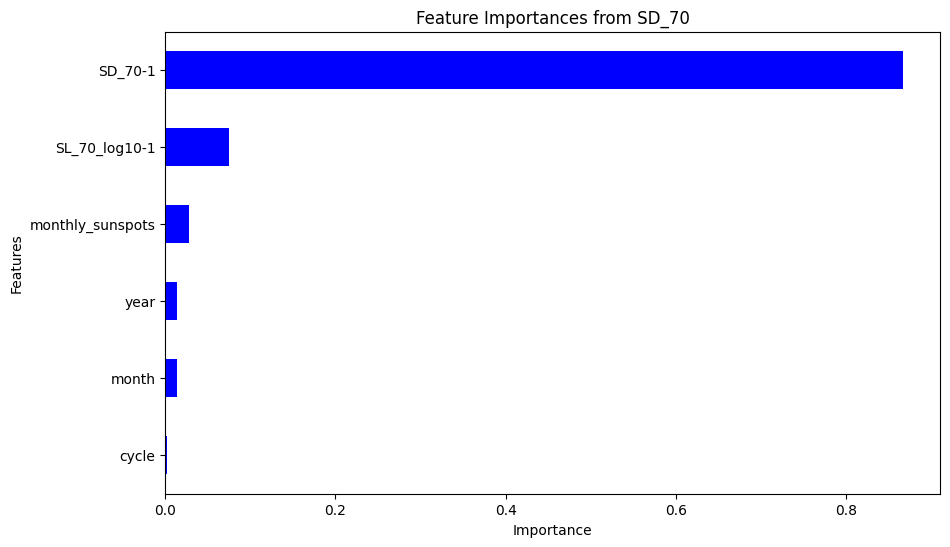

In [13]:
model = RandomForestRegressor()
mmodel_std = model.fit(X_train_std, y_train_std)

importances = model.feature_importances_

# Create a pandas series to hold the feature importances for better visualization
importances_df = pd.Series(importances, index=features.columns)

# # Plotting the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind='barh', color='blue')
plt.title('Feature Importances from SD_70')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

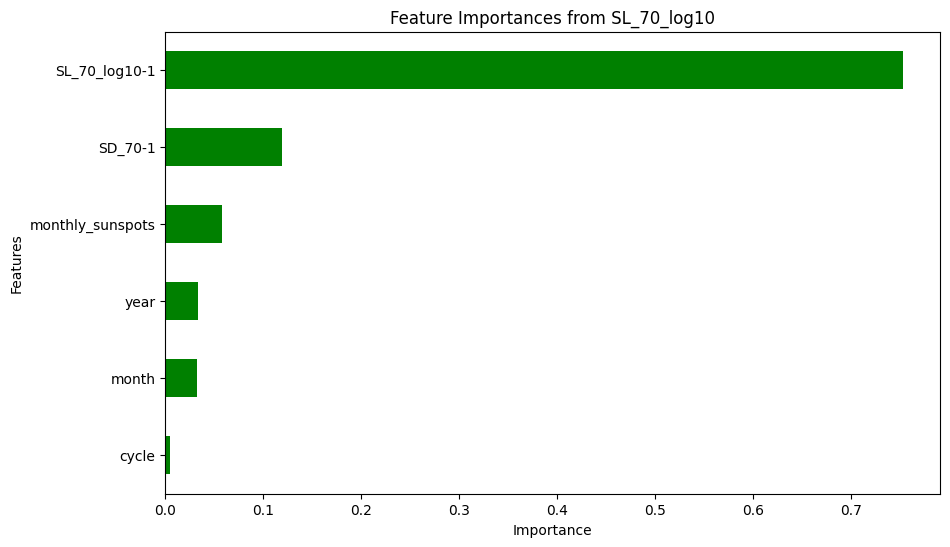

In [14]:
model = RandomForestRegressor()
mmodel_std = model.fit(X_train_slope, y_train_slope)

importances = model.feature_importances_

# Create a pandas series to hold the feature importances for better visualization
importances_df = pd.Series(importances, index=features.columns)

# # Plotting the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind='barh', color='green')
plt.title('Feature Importances from SL_70_log10')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### Redoing previous two steps based on the feature importances
Cycle seems to add no value so we are getting rid of it

In [15]:
#Selecting filters
features = hcs_sun_model[['monthly_sunspots','year','month','SD_70-1','SL_70_log10-1']]

#Scaling features
scaler = StandardScaler()

# Fit the scaler to your features and transform them
scaled = scaler.fit_transform(features)

#Putting them in a df for the patition
X = pd.DataFrame(scaled, columns=features.columns, index=features.index)

#Outcome variables
y_std = hcs_sun_model['SD_70']
y_slope = hcs_sun_model['SL_70_log10']

In [16]:
# STD Prediction
X_train_std = X.iloc[:split_point]
X_test_std = X.iloc[split_point+1:]  # Skip the first row in the test set to prevent data leakage
y_train_std = y_std.iloc[:split_point]
y_test_std = y_std.iloc[split_point+1:]  

# Slope Prediction
X_train_slope = X.iloc[:split_point]
X_test_slope = X.iloc[split_point+1:] 
y_train_slope = y_slope.iloc[:split_point]
y_test_slope = y_slope.iloc[split_point+1:]  

# Identifying the "best" model for each outcome variable

We want to see if different algorithms work better for each of the outcome variables, as they could behave different even though they are related. We added cross validation to this process because the results seems to good to be true.

In [17]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "Lasso": Lasso(random_state=42),
    "Ridge": Ridge(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42)
}

## SD_70 Model

In [18]:
results = []

# Define the number of folds for cross-validation
cv_folds = 5

# Loop through the models
for name, model in models.items():
    # Using cross-validation to evaluate model performance on Standard Deviation prediction
    cv_scores = cross_val_score(model, X_train_std, y_train_std, cv=cv_folds, scoring='r2')
    
    # Calculate mean and standard deviation of cross-validated R^2 scores
    mean_r2 = np.mean(cv_scores)
    std_r2 = np.std(cv_scores)

    # Train the model on the entire training dataset for detailed evaluation
    model.fit(X_train_std, y_train_std)
    y_pred_std = model.predict(X_test_std)
    
    # Calculate additional metrics
    std_mae = metrics.mean_absolute_error(y_test_std, y_pred_std)
    std_mse = metrics.mean_squared_error(y_test_std, y_pred_std)
    std_rmse = np.sqrt(std_mse)  # Calculate RMSE using the square root of MSE

    # Append results
    results.append({
        "Model": name,
        "Mean CV R^2": mean_r2,
        "Std Dev CV R^2": std_r2,
        "Test STD MAE": std_mae,
        "Test STD MSE": std_mse,
        "Test STD RMSE": std_rmse,
    })

# Convert results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df.sort_values(by="Mean CV R^2", ascending=False, inplace=True)  # Sort by Mean CV R^2 for easy comparison
results_df

,Model,Mean CV R^2,Std Dev CV R^2,Test STD MAE,Test STD MSE,Test STD RMSE
0,LinearRegression,0.784798,0.151703,1.489568,3.725764,1.930224
5,Ridge,0.784651,0.150915,1.495619,3.735733,1.932804
6,ExtraTreesRegressor,0.753322,0.167286,1.903254,5.732117,2.394184
3,GradientBoostingRegressor,0.741474,0.178344,2.329877,7.628636,2.761998
2,RandomForestRegressor,0.726895,0.197591,1.743157,4.952106,2.225333
4,Lasso,0.722385,0.184107,1.717816,4.847422,2.201686
1,DecisionTreeRegressor,0.452831,0.259352,2.619378,10.603354,3.256279


**Results**

Top Performers: **Linear Regression** and **Ridge Regression** are the best performers in terms of both accuracy and consistency. They are recommended for use in further analyses or operational models for predicting the SD_70.

Model Selection: The choice between these two might depend on further considerations such as simplicity of the model (favoring Linear Regression) or robustness to multicollinearity (favoring Ridge).

Considerations for Other Models: While ensemble models like RandomForest and GradientBoosting can capture complex nonlinear patterns, they do not seem to perform as well in this specific setting compared to the simpler models. This might be due to overfitting or the nature of the data not benefiting much from the complex structures these models build.

# SL_70_log10 Model

In [19]:
results = []

# Define the number of folds for cross-validation
cv_folds = 5

# Loop through the models
for name, model in models.items():
    # Using cross-validation to evaluate model performance on Slope prediction
    scores = cross_val_score(model, X_train_slope, y_train_slope, cv=cv_folds, scoring='r2')
    
    # Calculate mean of cross-validated scores
    mean_r2 = np.mean(scores)
    std_r2 = np.std(scores)

    # Train the model on the entire training dataset for detailed evaluation (optional)
    model.fit(X_train_slope, y_train_slope)
    y_pred_slope = model.predict(X_test_slope)
    
    # Calculate additional metrics
    slope_mae = metrics.mean_absolute_error(y_test_slope, y_pred_slope)
    slope_mse = metrics.mean_squared_error(y_test_slope, y_pred_slope)
    slope_rmse = np.sqrt(slope_mse)  # Calculate RMSE using the square root of MSE

    # Append results
    results.append({
        "Model": name,
        "Mean CV R^2": mean_r2,
        "Std Dev CV R^2": std_r2,
        "Test Slope MAE": slope_mae,
        "Test Slope MSE": slope_mse,
        "Test Slope RMSE": slope_rmse,
    })

# Convert results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df.sort_values(by="Mean CV R^2", ascending=False, inplace=True)
results_df

,Model,Mean CV R^2,Std Dev CV R^2,Test Slope MAE,Test Slope MSE,Test Slope RMSE
5,Ridge,0.594941,0.287875,0.217282,0.082393,0.287041
0,LinearRegression,0.594879,0.287852,0.216890,0.082218,0.286736
6,ExtraTreesRegressor,0.513920,0.353744,0.220380,0.085086,0.291695
2,RandomForestRegressor,0.507842,0.319461,0.268256,0.109820,0.331391
3,GradientBoostingRegressor,0.461919,0.327613,0.300369,0.129636,0.360051
1,DecisionTreeRegressor,0.084178,0.790332,0.340981,0.210452,0.458750
4,Lasso,-0.524541,0.679005,0.598394,0.455507,0.674913


**Results**

Best Performers: **Ridge** and **Linear Regression** are the top performers for modeling SL_70_log10, with Linear Regression slightly edging out in terms of lower errors. These models are recommended for further use and exploration in related tasks due to their relative stability and better predictive accuracy.

Potential Overfitting: The tree-based models, especially RandomForest and DecisionTree, appear to suffer from overfitting, as indicated by their poor performance metrics and high error rates.

Issues with Lasso: The Lasso model's negative R^2 suggests that it might be improperly specified or that the assumptions of Lasso (like linearity and normality) do not hold well for this dataset.

# Hyperparameter tuning

Since there's not much tuning with linear regression, we decided to proceed with Ridge for both models and see if we can optimize performance

In [20]:
# Define a range of alpha values for regularization
alpha_values = np.logspace(-4, 4, 50)

# Set up the expanded parameter grid
param_grid = {
    'alpha': alpha_values,
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000]
}

#For SD_70
# Initialize the GridSearchCV object
ridge_model_std = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Train the model on the training data
ridge_model_std.fit(X_train_std, y_train_std)

# Extracting the best hyperparameters
best_params_std = ridge_model_std.best_params_
print(f"model_std = Ridge(alpha={best_params_std['alpha']}, solver='{best_params_std['solver']}', max_iter={best_params_std['max_iter']})")



Fitting 5 folds for each of 900 candidates, totalling 4500 fits
model_std = Ridge(alpha=0.0001, solver='sag', max_iter=1000)


In [21]:
#For SL_70_log10
# Initialize the GridSearchCV object
ridge_model_slope = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Train the model on the training data
ridge_model_slope.fit(X_train_slope, y_train_slope)

# Extracting the best hyperparameters
best_params_slope = ridge_model_slope.best_params_
print(f"model_std = Ridge(alpha={best_params_slope['alpha']}, solver='{best_params_slope['solver']}', max_iter={best_params_slope['max_iter']})")


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
model_std = Ridge(alpha=3.727593720314938, solver='sag', max_iter=1000)


## Cross Validation using a Time Series Split

We wanted to see the CV for each fold for the tuned models.

In [22]:
# Initialize models
def get_best_ridge_model(best_params):
    return Ridge(alpha=best_params['alpha'], solver=best_params['solver'], max_iter=best_params['max_iter'], random_state=42)

model_std = get_best_ridge_model( best_params_std).fit(X_train_std, y_train_std)
model_std

Ridge(alpha=0.0001, max_iter=1000, random_state=42, solver='sag')

In [23]:
model_slope = get_best_ridge_model(best_params_slope).fit(X_train_slope, y_train_slope)
model_slope

Ridge(alpha=3.727593720314938, max_iter=1000, random_state=42, solver='sag')

In [24]:
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Evaluate the model for standard deviation
scores_std = cross_val_score(model_std, X, y_std, cv=tscv, scoring='r2')
print("R^2 scores for STD across time splits:", scores_std)

# Evaluate the model for slope
scores_slope = cross_val_score(model_slope, X, y_slope, cv=tscv, scoring='r2')
print("R^2 scores for Slope across time splits:", scores_slope)

R^2 scores for STD across time splits: [0.35954829 0.83764157 0.78939313 0.69263374 0.59499628 0.58230274
 0.77590209 0.59077414 0.77484752 0.74093059]
R^2 scores for Slope across time splits: [ 0.63235435  0.80988209  0.27523068  0.60438489  0.50820674 -0.17742367
  0.73032318  0.30941906  0.66969589  0.6762518 ]


**Analysis:**

Both models exhibit inconsistency in their performance across different time splits. This could be due to overfitting, underfitting, or changes in the underlying data characteristics across the timeline.

The variability suggests a need for making the models more robust. This might involve using regularization techniques, reevaluating the feature set, or using ensemble methods that might stabilize the predictions across different segments. In the future, different CV strategies could be explored.

## Outputting Evaluation Metrics for Best Tuned Models

In [25]:
best = []
# Define the number of folds for cross-validation
cv_folds = 5

#SD_70 Metrics
cv_scores = cross_val_score(model_std, X_train_std, y_train_std, cv=cv_folds, scoring='r2')   
mean_r2 = np.mean(cv_scores)
std_r2 = np.std(cv_scores)
std_mae = metrics.mean_absolute_error(y_test_std, y_pred_std)
std_mse = metrics.mean_squared_error(y_test_std, y_pred_std)
std_rmse = np.sqrt(std_mse)  # Calculate RMSE using the square root of MSE

# Append results
best.append({
        "Outcome Variable": 'SD_70',
        "Mean CV R^2": mean_r2,
        "STD Dev CV R^2": std_r2,
        "Test MAE": std_mae,
        "Test MSE": std_mse,
        "Test RMSE": std_rmse,
    })


#SL_70_log_10 Metrics
cv_scores = cross_val_score(model_slope, X_train_slope, y_train_slope, cv=cv_folds, scoring='r2')   
mean_r2 = np.mean(cv_scores)
slope_r2 = np.std(cv_scores)
slope_mae = metrics.mean_absolute_error(y_test_slope, y_pred_slope)
slope_mse = metrics.mean_squared_error(y_test_slope, y_pred_slope)
slope_rmse = np.sqrt(slope_mse)  # Calculate RMSE using the square root of MSE


# Append results
best.append({
        "Outcome Variable": 'SL_70_log_10',
        "Mean CV R^2": mean_r2,
        "STD Dev CV R^2": slope_r2,
        "Test MAE": slope_mae,
        "Test MSE": slope_mse,
        "Test RMSE": slope_rmse,
    })


# Convert results into a DataFrame for easy viewing
best_df = pd.DataFrame(best)
#results_df.sort_values(by="Mean CV R^2", ascending=False, inplace=True)  # Sort by Mean CV R^2 for easy comparison
best_df

,Outcome Variable,Mean CV R^2,STD Dev CV R^2,Test MAE,Test MSE,Test RMSE
0,SD_70,0.784802,0.151703,1.903254,5.732117,2.394184
1,SL_70_log_10,0.595062,0.287922,0.220380,0.085086,0.291695


In [26]:
#Outputting Predictions on Test Set to be plotted later

predictions_std = pd.DataFrame(model_std.predict(X_test_std), index=X_test_std.index, columns=['Predicted Values'])
predictions_slope = pd.DataFrame(model_slope.predict(X_test_slope), index=X_test_slope.index, columns=['Predicted Values'])



# Generating Future Predictions

This proved to be trickier than expected becuase we are using lag columns as features. In order to generate future predictors, we needed to have forecated sunspot numbers and lag columns. Our goal is to generate 2 years (24 months) from the last HCS observation date available (May 2022).

### Forecasted Monthly Sunspot Numbers

These were obtained from the National Oceanic and Atmospheric Administration (NOAA). Through their website forecasted sunspots can be obtained here:


**Predicted Solar Cycle: Sunspot Number And Radio Flux Values with Expected Ranges**

https://www.swpc.noaa.gov/products/solar-cycle-progression#:~:text=The%20Prediction%20Panel%20predicted%20Cycle,November%202024%20and%20March%202026.&text=SWPC%20Space%20Weather%20Operations%20(SWO)%2C%20Daily%20Observations.

Sources
- S.I.D.C. Brussels International Sunspot Number, Data Files(link is external).​
- Penticton, B.C., Canada: 10.7cm radio flux values (sfu), Data Files(link is external).
- Predicted values are based on the consensus of the Solar Cycle 25 Prediction Panel​

Fields (JSON)
- time-tag: yyyy-mm
- predicted_ssn: predicted sunspot number
- high_ssn: predicted sunspot number high range
- low_ssn: predicted sunspot number low range
- predicted_f10.7: predicted f10.7cm value
- high_f10.7: predicted f10.7cm high range
- low_f10.7: predicted f10.7cm low range

In [27]:
#Reading
sun_forecast = pd.read_json('../data/Sunspot Number NASA.json')

#Data preprocessong
sun_forecast['time-tag'] = pd.to_datetime(sun_forecast['time-tag']) 
sun_forecast['year'] = sun_forecast['time-tag'].dt.year
sun_forecast['month'] = sun_forecast['time-tag'].dt.month

print("Earliest Prediction Available: ",sun_forecast['time-tag'].min())
#To not overlap with the set below
sun_forecast = sun_forecast[['time-tag','predicted_ssn','year','month']].loc[sun_forecast['year']>=2024]


Earliest Prediction Available:  2023-10-01 00:00:00


Since we didn't have forecasted monthly susnpots available, we decided to pull the actual values. However, our original sunspot set ended on April 2023, so we had to source the data from NOAA as well, which is available on the sabe webpage under:

**Observed Solar Cycle Indices: Recent Solar Indices of Observed Monthly Mean Values**

In [28]:
#Reading
sun_history = pd.read_json('../data/observed-solar-cycle-indices.json')

#Pre-processing
sun_history['time-tag'] = pd.to_datetime(sun_history['time-tag'], format='%Y-%m')
sun_history['year'] = sun_history['time-tag'].dt.year
sun_history['month'] = sun_history['time-tag'].dt.month

#To not overlap with the other set
sun_history = sun_history[['time-tag','ssn','year','month']].loc[sun_history['year']<=2023]

sun_history = sun_history.rename(columns={'ssn':'predicted_ssn'})

In [29]:
#Concatening both to get continuous monthly sunspots to be use after for future forecasting
f_features = pd.concat([sun_forecast, sun_history]).reset_index(drop=True)

f_features = f_features.rename(columns={'time-tag':'date'})
f_features.set_index('date', inplace=True)
f_features.sort_index(inplace=True)
f_features = f_features.rename(columns={'predicted_ssn':'monthly_sunspots'})
f_features.head()

,monthly_sunspots,year,month
date,,,
1749-01-01,96.7,1749,1
1749-02-01,104.3,1749,2
1749-03-01,116.7,1749,3
1749-04-01,92.8,1749,4
1749-05-01,141.7,1749,5


### Forecasting Lag columns

Creating a separate model without the lags.

In [30]:
hcs_sun_model_l = hcs_sun.copy().dropna()

#Selecting filters
features_l = hcs_sun_model_l[['monthly_sunspots','year','month']]


#Scaling features
scaler_l = StandardScaler()

# Fit the scaler to your features and transform them
scaled_l = scaler_l.fit_transform(features_l)

#Putting them in a df for the patition
X_l = pd.DataFrame(scaled_l, columns=features_l.columns, index=features_l.index)

split_point_l = int(len(hcs_sun_model_l) * 0.8)

#Outcome variables
y_std_l = hcs_sun_model_l['SD_70']

X_train_std_l = X_l.iloc[:split_point_l]
X_test_std_l = X_l.iloc[split_point_l:] 
y_train_std_l = y_std_l.iloc[:split_point_l]
y_test_std_l = y_std_l.iloc[split_point_l:]

model_std_l = get_best_ridge_model(best_params_std)
model_std_l.fit(X_train_std_l, y_train_std_l)

y_slope_l = hcs_sun_model_l['SL_70_log10']

X_train_slope_l = X_l.iloc[:split_point_l]
X_test_slope_l = X_l.iloc[split_point_l:]  
y_train_slope_l = y_slope_l.iloc[:split_point_l]
y_test_slope_l = y_slope_l.iloc[split_point_l:]

model_slope_l = get_best_ridge_model(best_params_slope)
model_slope_l.fit(X_train_slope_l, y_train_slope_l)


Ridge(alpha=3.727593720314938, max_iter=1000, random_state=42, solver='sag')

#### Genrating the forecasted lag for SD_70

In [31]:
df = hcs_sun_model_l.copy()
df.set_index('date', inplace=True)

warnings.filterwarnings("ignore", message="X does not have valid feature names, but*")

# Storing the last row to use for initial predictions
last_known_data = df.iloc[-1:]
features = ['monthly_sunspots', 'year', 'month']

# Initialize a DataFrame for the next row to predict
next_row = pd.DataFrame({'date': pd.date_range(last_known_data.index[0] + pd.DateOffset(months=1), periods=1, freq='ME')})
next_row['date'] = next_row['date'].apply(lambda x: x.replace(day=1))

# Setting initial lag value from last known data
next_row['lag1'] = last_known_data['SD_70'].values[0]

# Create an empty DataFrame to store all forecasts
all_forecasts_sd = pd.DataFrame()

# Define the feature preparation function
def prepare_features(next_row, features_list):
    feature_data = {
        'monthly_sunspots': [next_row['lag1'].iloc[0]], 
        'year': [next_row['date'].dt.year.iloc[0]],
        'month': [next_row['date'].dt.month.iloc[0]]
    }
    return pd.DataFrame(feature_data)

# Loop to generate each forecast one at a time and use each forecast as input for the next
window = 24
for i in range(window):
    # Prepare the features for forecasting
    prepared_features = prepare_features(next_row, features)
    prepared_features_scaled = scaler_l.transform(prepared_features) 

    # Predicting the next value using the model_std model
    forecasted_value = model_std_l.predict(prepared_features_scaled)  # Adjust this if your model output structure differs

    # Append the forecasted value to the DataFrame
    next_row['forecasted_value'] = forecasted_value[0] if isinstance(forecasted_value, (list, np.ndarray)) else forecasted_value
    all_forecasts_sd = pd.concat([all_forecasts_sd, next_row], ignore_index=True)

    # Update the 'lag1' for the next prediction to the newly forecasted value
    next_row['lag1'] = forecasted_value[0] if isinstance(forecasted_value, (list, np.ndarray)) else forecasted_value

    # Update the 'date' for the next prediction
    next_row['date'] = next_row['date'] + pd.DateOffset(months=1)

all_forecasts_sd.set_index('date', inplace=True)

# Optionally display the forecasts
print(all_forecasts_sd)



                 lag1  forecasted_value
date                                   
2022-06-01  20.662584         13.886300
2022-07-01  13.886300         13.358419
2022-08-01  13.358419         13.240167
2022-09-01  13.240167         13.148769
2022-10-01  13.148769         13.059132
2022-11-01  13.059132         12.969610
2022-12-01  12.969610         12.880096
2023-01-01  12.880096         13.981755
2023-02-01  13.981755         13.970331
2023-03-01  13.970331         13.885937
2023-04-01  13.885937         13.796759
2023-05-01  13.796759         13.707267
2023-06-01  13.707267         13.617754
2023-07-01  13.617754         13.528240
2023-08-01  13.528240         13.438727
2023-09-01  13.438727         13.349213
2023-10-01  13.349213         13.259699
2023-11-01  13.259699         13.170185
2023-12-01  13.170185         13.080671
2024-01-01  13.080671         14.182331
2024-02-01  14.182331         14.170907
2024-03-01  14.170907         14.086512
2024-04-01  14.086512         13.997334


#### Genrating the forecasted lag for SL_70_log10

In [32]:
df = hcs_sun_model_l.copy()
df.set_index('date', inplace=True)

warnings.filterwarnings("ignore", message="X does not have valid feature names, but*")

# Storing the last row to use for initial predictions
last_known_data = df.iloc[-1:]
features = ['monthly_sunspots', 'year', 'month']

# Initialize a DataFrame for the next row to predict
next_row = pd.DataFrame({'date': pd.date_range(last_known_data.index[0] + pd.DateOffset(months=1), periods=1, freq='ME')})
next_row['date'] = next_row['date'].apply(lambda x: x.replace(day=1))

# Setting initial lag value from last known data
next_row['lag1'] = last_known_data['SL_70_log10'].values[0]

# Create an empty DataFrame to store all forecasts
all_forecasts_sl = pd.DataFrame()

# Define the feature preparation function
def prepare_features(next_row, features_list):
    feature_data = {
        'monthly_sunspots': [next_row['lag1'].iloc[0]], 
        'year': [next_row['date'].dt.year.iloc[0]],
        'month': [next_row['date'].dt.month.iloc[0]]
    }
    return pd.DataFrame(feature_data)

# Loop to generate each forecast one at a time and use each forecast as input for the next
for i in range(window):
    # Prepare the features for forecasting
    prepared_features = prepare_features(next_row, features)
    prepared_features_scaled = scaler_l.transform(prepared_features) 

    # Predicting the next value using the model_std model
    forecasted_value = model_slope_l.predict(prepared_features_scaled)  # Adjust this if your model output structure differs

    # Append the forecasted value to the DataFrame
    next_row['forecasted_value'] = forecasted_value[0] if isinstance(forecasted_value, (list, np.ndarray)) else forecasted_value
    all_forecasts_sl = pd.concat([all_forecasts_sl, next_row], ignore_index=True)

    # Update the 'lag1' for the next prediction to the newly forecasted value
    next_row['lag1'] = forecasted_value[0] if isinstance(forecasted_value, (list, np.ndarray)) else forecasted_value

    # Update the 'date' for the next prediction
    next_row['date'] = next_row['date'] + pd.DateOffset(months=1)

all_forecasts_sl.set_index('date', inplace=True)

# Optionally display the forecasts
print(all_forecasts_sl)


                lag1  forecasted_value
date                                  
2022-06-01  2.600351          2.167766
2022-07-01  2.167766          2.162325
2022-08-01  2.162325          2.159483
2022-09-01  2.159483          2.156656
2022-10-01  2.156656          2.153829
2022-11-01  2.153829          2.151003
2022-12-01  2.151003          2.148176
2023-01-01  2.148176          2.197143
2023-02-01  2.197143          2.194632
2023-03-01  2.194632          2.191807
2023-04-01  2.191807          2.188980
2023-05-01  2.188980          2.186154
2023-06-01  2.186154          2.183327
2023-07-01  2.183327          2.180501
2023-08-01  2.180501          2.177674
2023-09-01  2.177674          2.174847
2023-10-01  2.174847          2.172021
2023-11-01  2.172021          2.169194
2023-12-01  2.169194          2.166368
2024-01-01  2.166368          2.215334
2024-02-01  2.215334          2.212823
2024-03-01  2.212823          2.209998
2024-04-01  2.209998          2.207172
2024-05-01  2.207172     

# Putting it all together

Now that we have all the forecasted features we can genrate the future forecasts

In [33]:
#SD_70
model_std = get_best_ridge_model( best_params_std)
model_std.fit(X_train_std, y_train_std)

#SL_70_log10
model_slope = get_best_ridge_model( best_params_slope)
model_slope.fit(X_train_slope, y_train_slope)

Ridge(alpha=3.727593720314938, max_iter=1000, random_state=42, solver='sag')

In [34]:
# Getting the actulas
#split_point = int(len(hcs_sun_model) * 0.8)
historical_std = hcs_sun_model['SD_70']
historical_slope = hcs_sun_model['SL_70_log10']

# Generating future dates and dummy data for predictions
last_date = last_known_data.index[0]
future_dates = pd.date_range(start=last_known_data.index[0]  + pd.Timedelta(days=1), periods=window, freq='MS')   # 24 months ahead

#Loading the forecasted features
future_sunspots = f_features.loc[historical_std.index[-1]:]['monthly_sunspots'].iloc[:window].to_numpy()
future_SD_70_1 = all_forecasts_sd.loc[historical_std.index[-1]:]['forecasted_value'].iloc[:window].to_numpy()
future_SL_70_log10_1 = all_forecasts_sl.loc[historical_std.index[-1]:]['forecasted_value'].iloc[:window].to_numpy()

#Cosolidating everything in a df
future_features = pd.DataFrame({
    'monthly_sunspots': future_sunspots,
    'year': future_dates.year,
    'month': future_dates.month,
    'SD_70-1': future_SD_70_1,
    'SL_70_log10-1': future_SL_70_log10_1
}, index=future_dates)

# Scaling and predicting
scaler = StandardScaler().fit(hcs_sun_model[['monthly_sunspots', 'year', 'month', 'SD_70-1', 'SL_70_log10-1']][:split_point])  # Fit scaler to historical data only
scaled_future_features = scaler.transform(future_features)
X_future = pd.DataFrame(scaled_future_features, columns=future_features.columns, index=future_features.index)
future_std_predictions = model_std.predict(X_future)
future_slope_predictions = model_slope.predict(X_future)


#Filtering data for better visualization
s_year = 2005
historical_std = historical_std[historical_std.index.year >= s_year]
predictions_std = predictions_std[predictions_std.index.year >= s_year]
historical_slope = historical_slope[historical_slope.index.year >= s_year]
predictions_slope = predictions_slope[predictions_slope.index.year >= s_year]


### Actuals vs. Predicted Plot

After generating the predictions, we plotted the Actuals, the Predictions on the Test Set, and the Future Predictions.

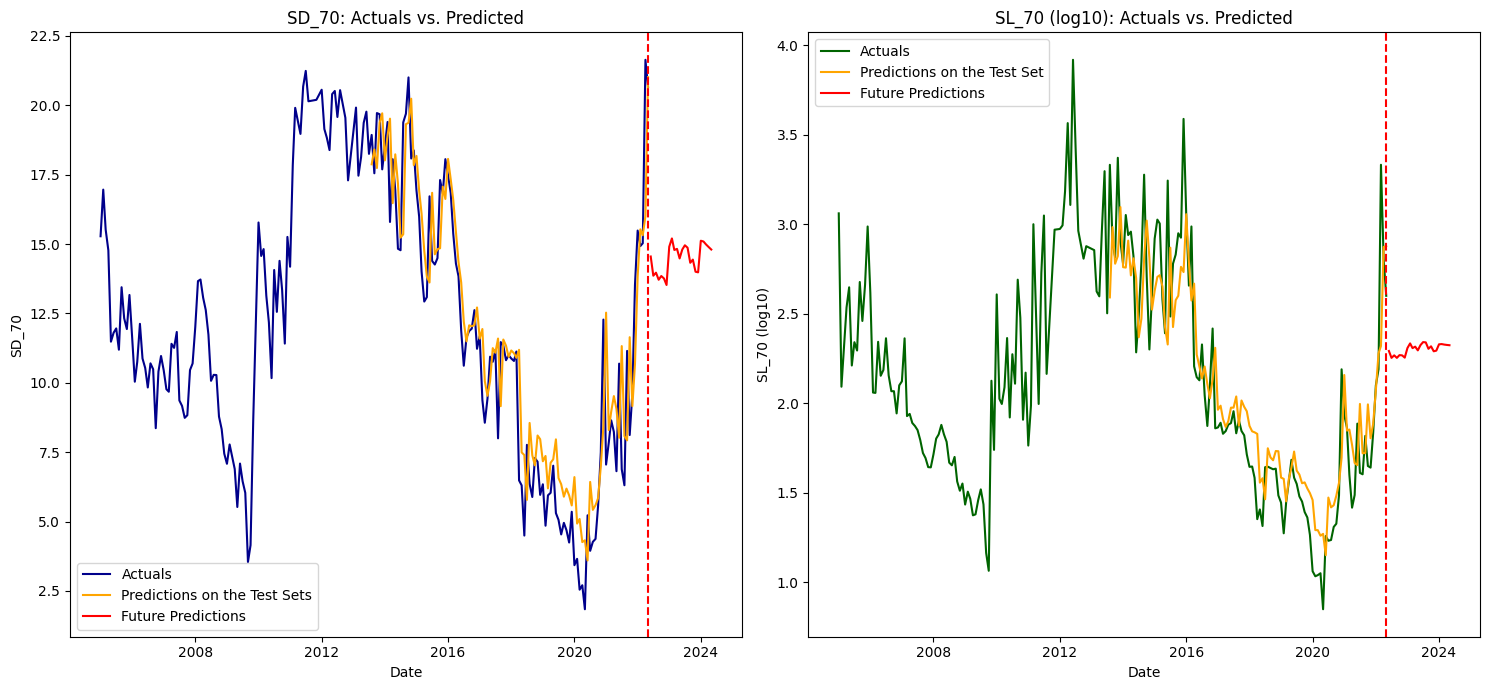

In [35]:
# Creating plot
plt.figure(figsize=(15, 7))

# Standard Deviation Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(historical_std.index, historical_std, label='Actuals', color='darkblue')
plt.plot(predictions_std.index, predictions_std['Predicted Values'], label='Predictions on the Test Sets', color = 'orange')
plt.axvline(x=last_date, color='r', linestyle='--')
plt.plot(future_dates, future_std_predictions, label='Future Predictions', color='red', linestyle='-')
plt.title('SD_70: Actuals vs. Predicted')
plt.xlabel('Date')
plt.ylabel('SD_70')
plt.legend()

# Slope Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(historical_slope.index, historical_slope, label='Actuals', color='darkgreen')
plt.plot(predictions_slope.index, predictions_slope['Predicted Values'], label='Predictions on the Test Set', color = 'orange')
plt.axvline(x=last_date, color='r', linestyle='--')
plt.plot(future_dates, future_slope_predictions, label='Future Predictions', color='red', linestyle='-')
plt.title('SL_70 (log10): Actuals vs. Predicted')
plt.xlabel('Date')
plt.ylabel('SL_70 (log10)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The forecasted features add uncertainty to the future forecasts. When new HCS is available, this code can be used to compare predictions and improve future modeling.